/tmp/ipykernel_135958/4096868178.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['chr1' 'chr1' 'chr11' 'chr14' 'chr16' 'chr17' 'chr17' 'chr22' 'chr22'
 'chr3' 'chr4' 'chr6']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  edi.loc[:, "Chromosome"] = edi.loc[:, "Chromosome"].apply(return_region)
/tmp/ipykernel_135958/4096868178.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1' 'chr1'
 

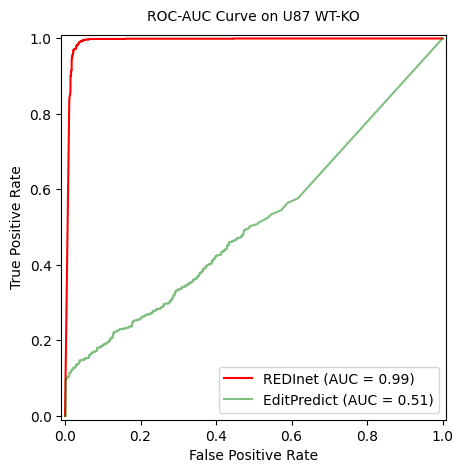

In [132]:
import pandas as pd
import os, gzip
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, classification_report
from sklearn import metrics

datapath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

tables = ["outTable_853538513", "outTable_921089530"]

sites = pd.read_table(os.path.join(datapath, f"{tables[0]}_{tables[1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])

y_true_edi = []
y_pred_edi = []
y_pred_edi_class = []
edi_chr = []
edi_region = []

y_true_redi = []
y_pred_redi = []

for table in tables:
    for rep in ["alu", "not_alu"]:

        edi = pd.read_table(os.path.join(datapath, f"{table}_editpredict_predictions_{rep}.txt"), usecols=["Chromosome", "Position", "RNAEditing", "NO_prob"])
        edi.loc[:, "Chromosome"] = edi.loc[:, "Chromosome"].apply(return_region)
        edi.loc[:, "NO_prob"] = edi.loc[:, "NO_prob"].astype("float64")
        edi.loc[:, "Position"] = edi.loc[:, "Position"].astype("int64")
        edi.loc[:, "RNAEditing"] = edi.loc[:, "RNAEditing"].astype("int64")
        
        edi.loc[:, "EditPredict_Probability"] = 1.0 - edi.loc[:,  "NO_prob"]
        edi.columns = ["Region", "Position", "RNAEditing", "NO_prob", "EditPredict_Probability"]

        edi = edi.merge(sites, how="inner", on=["Region", "Position"])

        y_true_edi += edi.loc[:, "Class"].tolist()
        y_pred_edi += edi.loc[:, "EditPredict_Probability"].tolist()
        y_pred_edi_class += edi.loc[:, "RNAEditing"].tolist()
        edi_chr +=  edi.loc[:, "Region"].tolist()
        edi_region += edi.loc[:, "Position"].tolist()
        
         
    redi = pd.read_table(f"{datapath}/{table}_predictions.tsv", usecols=["Region", "Position", "Editing_Probability"])
    
    if table == "outTable_921089530":
        neg = sites[sites["Class"]==0]
        redi = redi.merge(neg, how="inner", on=["Region", "Position"])
    else:
        redi = redi.merge(sites, how="inner", on=["Region", "Position"])

    y_true_redi += redi.loc[:, "Class"].tolist()
    y_pred_redi += redi.loc[:, "Editing_Probability"].tolist()

fig, ax = plt.subplots(figsize=(5.5, 5))
fpr_redi, tpr_redi, thresholds_redi = metrics.roc_curve(y_true_redi, y_pred_redi)
AUC_redi = metrics.auc(fpr_redi, tpr_redi,)
ROC = metrics.RocCurveDisplay(fpr=fpr_redi, tpr=tpr_redi, roc_auc=AUC_redi).plot(ax=ax, color="red", name="REDInet")
fpr_edi, tpr_edi, thresholds_edi = metrics.roc_curve(y_true_edi, y_pred_edi)
AUC_edi = metrics.auc(fpr_edi, tpr_edi)
ROC_edi = metrics.RocCurveDisplay(fpr=fpr_edi, tpr=tpr_edi, roc_auc=AUC_edi).plot(ax=ax, color="green", name="EditPredict", alpha=0.5) 

ax.set_title(f"ROC-AUC Curve on U87 WT-KO", fontsize=10, pad=10)
plt.savefig(f"{datapath}/ROC-AUC_on_U87_WT_KO.tiff", dpi=300, facecolor='white', transparent=False) 
plt.show()